## Requerimiento 1
#### **implementacion de la arquitectura cluster con un set de 3 replicas**
- Mapeamos los puertos que vamos a utilizar en nuestra IP local conectandonos a la terminal y agregando los puertos

In [ ]:
# En linux:
sudo nano /etc/hosts

 Desde aqui, nos aparecera la instancia de nuestro host, asi que integramos los puertos que usaremos agregando este codigo al final

In [ ]:
127.0.0.1 mongo1
127.0.0.1 mongo2
127.0.0.1 mongo3

- Ejecutamons nuestro codigo deploy-202273503-1-202273641-0.yml para configurar los contenedores usando en la terminal el comando 
`docker compose -f deploy-202273503-1-202273641-0.yml up -d`

In [ ]:
# deploy-202273503-1-20227361-0.yml

version: "3.8"

services:
  mongo1:
    image: mongo:5
    container_name: mongo1
    command: ["--replSet", "my-replica-set", "--bind_ip_all", "--port", "30001"]
    volumes:
      - ./data/mongo-1:/data/db
    ports:
      - 30001:30001
    healthcheck:
      test: test $$(echo "rs.initiate({_id:'my-replica-set',members:[{_id:0,host:\"mongo1:30001\"},{_id:1,host:\"mongo2:30002\"},{_id:2,host:\"mongo3:30003\"}]}).ok || rs.status().ok" | mongo --port 30001 --quiet) -eq 1
      interval: 10s
      start_period: 30s

  mongo2:
    image: mongo:5
    container_name: mongo2
    command: ["--replSet", "my-replica-set", "--bind_ip_all", "--port", "30002"]
    volumes:
      - ./data/mongo-2:/data/db
    ports:
      - 30002:30002

  mongo3:
    image: mongo:5
    container_name: mongo3
    command: ["--replSet", "my-replica-set", "--bind_ip_all", "--port", "30003"]
    volumes:
      - ./data/mongo-3:/data/db
    ports:
      - 30003:30003


Con esto deberiamos tener nuestros contenedores arriba y ser visible en nuestro docker desktop ✅

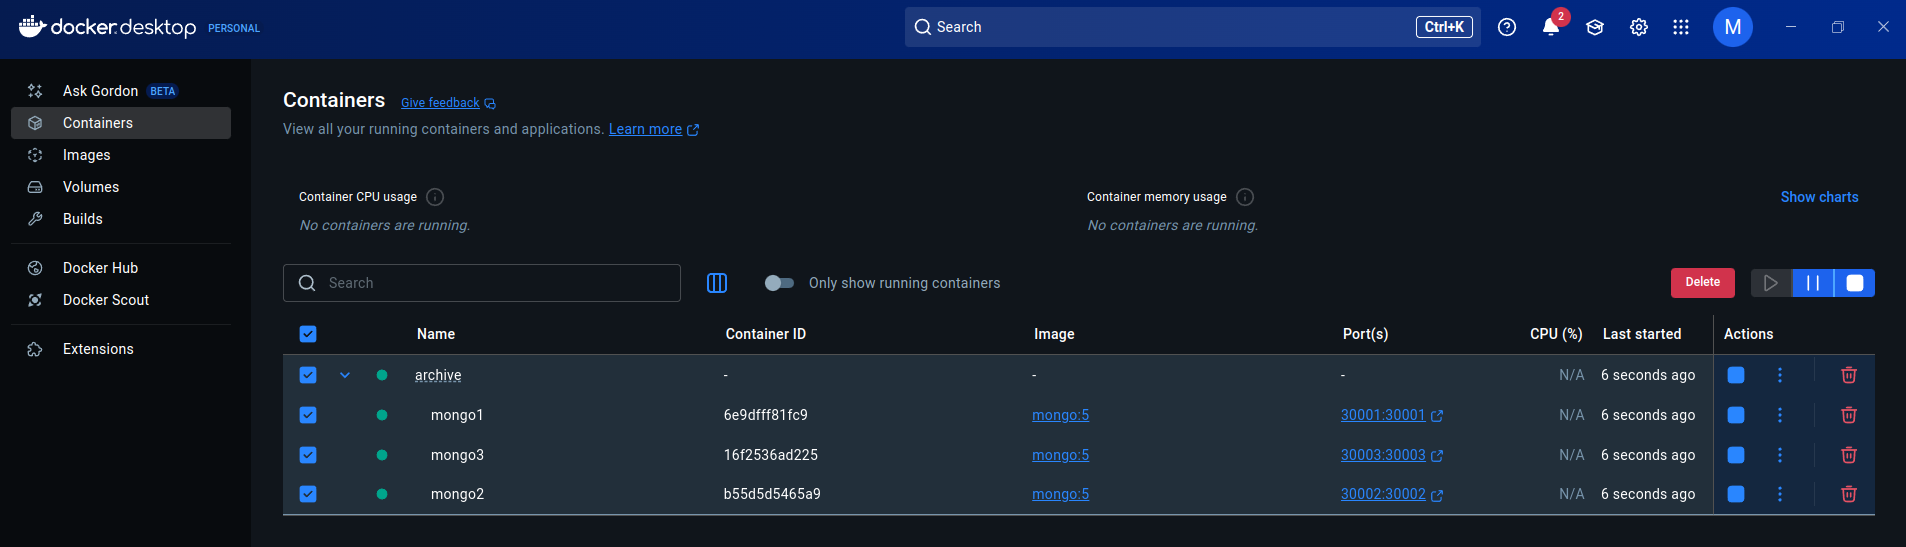
- Ahora poblaremos de articulos nuestro set utilizando el siguiente codigo de python

In [ ]:
# arXiv_edited.py

# === librerias ===
import json
from pymongo import MongoClient
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# === Configuración ===
json_file_path = "arxiv-metadata-oai-snapshot.json"
#Estas variables manejarlas segun la potencia del pc
batch_size = 2000   # Modificar segun la potencia del PC, mayor el numero => mayor velocidad de subida
max_workers = 8     # tener en cuenta los nucleos logicos de tu PC
max_pending_batches = max_workers * 2 # Mantenlo como multiplo de max_workers, en este caso seran 16

# === Conectar a MongoDB ===
#nos conectamos a los puertos de nuestro set
client = MongoClient("mongodb://mongo1:30001,mongo2:30002,mongo3:30003/?replicaSet=my-replica-set&readPreference=primary&appname=MongoDB%20Compass&ssl=false")
db = client["arxiv_db"]
collection = db["articles"]

# === Función para insertar lote ===
def insert_batch(batch):
    try:
        collection.insert_many(batch, ordered=False)
    except Exception as e:
        print("Error al insertar batch:", e)

# === Lectura + carga paralela ===
with open(json_file_path, 'r', encoding='utf-8') as f, tqdm(desc="Cargando artículos") as pbar:
    current_batch = []
    pending_futures = [] # Lista para almacenar los objetos Future

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for line_num, line in enumerate(f): # line_num puede ser útil para depuración
            try:
                record = json.loads(line)
                # 👉 Agregar campo pdf_source
                record["pdf_source"] = f"https://arxiv.org/pdf/{record['id']}"
                current_batch.append(record)

                if len(current_batch) >= batch_size:
                    # Envia el lote para inserción y guarda el Future
                    future = executor.submit(insert_batch, list(current_batch)) # Se pasa una copia del batch
                    pending_futures.append(future)
                    current_batch = [] # Reinicia el lote

                    # === Control de flujo: Esperar si hay demasiados lotes pendientes ===
                    if len(pending_futures) >= max_pending_batches:
                        # Espera a que las tareas más antiguas se completen
                        # as_completed devuelve los futures a medida que se completan
                        for completed_future in as_completed(pending_futures):
                            try:
                                completed_future.result() # Obtiene el resultado (o re-lanza excepción)
                            except Exception as e:
                                print(f"Error en una tarea completada: {e}")
                            # Una vez que una tarea se completa, la eliminamos de la lista
                            pending_futures.remove(completed_future)
                            # Si ya no tenemos demasiados lotes pendientes, podemos seguir enviando
                            if len(pending_futures) < max_pending_batches:
                                break # Salir del bucle interno y continuar leyendo líneas

            except json.JSONDecodeError:
                # Omitir líneas que no son JSON válido, pero considera registrarlo si es inesperado
                # print(f"Saltando línea JSON mal formada en la línea {line_num + 1}: {line.strip()}")
                continue
            pbar.update(1) # Actualiza la barra de progreso por cada línea procesada

        # === Último batch (si queda algo después del bucle) ===
        if current_batch:
            future = executor.submit(insert_batch, list(current_batch))
            pending_futures.append(future)

        # === Esperar a que terminen todas las cargas restantes ===
        # Fuera del bucle principal, esperamos a que todas las tareas pendientes finalicen
        for completed_future in as_completed(pending_futures):
            try:
                completed_future.result()
            except Exception as e:
                print(f"Error en una tarea final pendiente: {e}")

print("✅ Carga paralela completa.")

Codigo para borrar los articulos de los contenedores

In [ ]:
'''
from pymongo import MongoClient

client = MongoClient("mongodb://mongo1:30001,mongo2:30002,mongo3:30003/?replicaSet=my-replica-set&readPreference=primary&appname=MongoDB%20Compass&ssl=false")
db = client["arxiv_db"]
collection = db["articles"]

# ⚠️ Eliminar todos los documentos
collection.delete_many({})
print("🗑️ Todos los documentos eliminados.")
'''

Con esto ya tendriamos poblado los articulos en nuestros conteiner ✅, podemos visualizar los datos tanto desde la terminal como desde MongoDB Compass. En caso del segundo solo bastaria con usar la direccion de los puertos `mongodb://mongo1:30001,mongo2:30002,mongo3:30003/?replicaSet=my-replica-set&readPreference=primary&ssl=false`

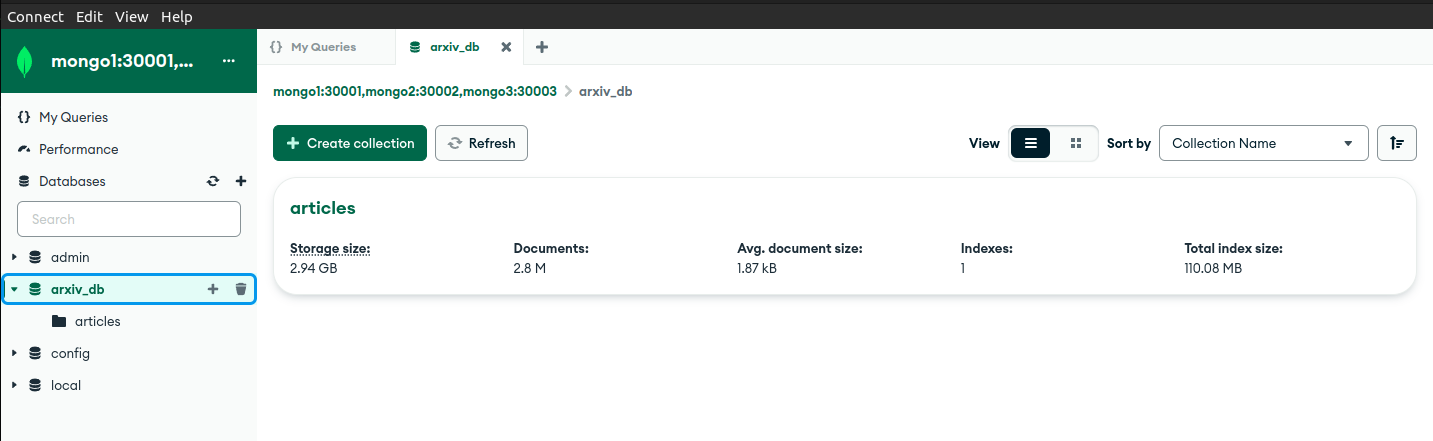

## Requerimiento 2
#### **Realización de consultas en python requeridas para resolver las preguntas del negocio a traves del cliente** 

Primero realizamos una conexion a la base de datos que nos servira para todas las consultas y creamos una funcion que nos permita realizar las consultas

In [25]:
# === librerias ===
import json
import time
from pymongo import MongoClient
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# === Conectar a MongoDB ===
#nos conectamos a los puertos de nuestro set
client = MongoClient("mongodb://mongo1:30001,mongo2:30002,mongo3:30003/?replicaSet=my-replica-set&readPreference=primary&appname=MongoDB%20Compass&ssl=false")
db = client["arxiv_db"]
collection = db["articles"]

# === Funcion ===
#Funcion que devuelve un cursos con un diccionario de datos.
def print_resultados (res):
    if not res:
        print("No se han encontrado resultados.")
        return
    for i in res:
        print(i)

- a. Devolver los títulos y fechas de creación de artículos publicados en el año 2025. Mostrarsolo esos campos y limitar a los primeros 20 resultados. ✅

In [22]:
# Devuelve los primeros 20 artículos publicados en 2025, ordenados por fecha de actualización
# Filtramos artículos que su publicacion haya sido el 2025
consulta = {
    "versions.0.created": {"$regex": "2025"}
}

# Mostramos el título y la fecha de la primera versión
proyeccion = {
    "title": 1,
    "first_version_date": {"$arrayElemAt": ["$versions.created", 0]},  # Extrae la primera fecha dentro del array
    "_id": 0
}

# Ejecutamos la consulta, limitando a los primeros 20 resultados
resultados = collection.find(consulta, proyeccion).sort("first_version_date", 1).limit(20)
print_resultados(resultados)

{'title': 'Quantum Cognition-Inspired EEG-based Recommendation via Graph Neural\n  Networks', 'first_version_date': 'Sun, 5 Jan 2025 21:45:13 GMT'}
{'title': 'Multi-LLM Collaborative Caption Generation in Scientific Documents', 'first_version_date': 'Sun, 5 Jan 2025 14:09:12 GMT'}
{'title': 'Enhancing Contrastive Learning for Retinal Imaging via Adjusted\n  Augmentation Scales', 'first_version_date': 'Sun, 5 Jan 2025 06:08:08 GMT'}
{'title': 'Multispectral Pedestrian Detection with Sparsely Annotated Label', 'first_version_date': 'Sun, 5 Jan 2025 20:05:10 GMT'}
{'title': 'Hierarchical self-assembly for high-yield addressable complexity at\n  fixed conditions', 'first_version_date': 'Sun, 5 Jan 2025 17:40:19 GMT'}
{'title': 'Vision-Driven Prompt Optimization for Large Language Models in\n  Multimodal Generative Tasks', 'first_version_date': 'Sun, 5 Jan 2025 13:01:47 GMT'}
{'title': 'Flash Interpretability: Decoding Specialised Feature Neurons in Large\n  Language Models with the LM-Head

In [9]:
# Devuelve los primeros 20 artículos que encuentra publicados en 2025
# Filtramos artículos que su publicacion haya sido el 2025
consulta = {
    "versions.0.created": {"$regex": "2025"}
}

# Mostramos el título y la fecha de la primera versión
proyeccion = {
    "title": 1,
    "first_version_date": {"$arrayElemAt": ["$versions.created", 0]},  # Extrae la primera fecha dentro del array
    "_id": 0
}

# Ejecutamos la consulta, limitando a los primeros 20 resultados
resultados = collection.find(consulta, proyeccion).limit(20)
print_resultados(resultados)

{'title': 'Framework for lung CT image segmentation based on UNet++', 'first_version_date': 'Sun, 5 Jan 2025 03:23:39 GMT'}
{'title': 'An Analysis Framework for Understanding Deep Neural Networks Based on\n  Network Dynamics', 'first_version_date': 'Sun, 5 Jan 2025 04:23:21 GMT'}
{'title': 'MedSegDiffNCA: Diffusion Models With Neural Cellular Automata for Skin\n  Lesion Segmentation', 'first_version_date': 'Sun, 5 Jan 2025 05:54:27 GMT'}
{'title': 'Understand, Solve and Translate: Bridging the Multilingual Mathematical\n  Reasoning Gap', 'first_version_date': 'Sun, 5 Jan 2025 05:57:22 GMT'}
{'title': 'Enhancing Contrastive Learning for Retinal Imaging via Adjusted\n  Augmentation Scales', 'first_version_date': 'Sun, 5 Jan 2025 06:08:08 GMT'}
{'title': 'H0 tension in Tsallis and Renyi statistics', 'first_version_date': 'Sun, 5 Jan 2025 06:45:36 GMT'}
{'title': 'LLMPC: Large Language Model Predictive Control', 'first_version_date': 'Sun, 5 Jan 2025 09:37:23 GMT'}
{'title': 'Wide-angle pi

- b. Devolver los títulos y los autores de artículos que pertenezcan a las categorías "cs.AI" o "stat.ML" y que tengan al menos tres autores. Mostrar solo esos campos y limitar a los primeros 10 resultados. ✅

In [20]:
#obtenemos los articulos que tengan la categoria deseada y que tengan autores
consulta = {
    "categories": {"$in": ["cs.AI", "stat.ML"]},
    "authors_parsed": {"$exists": True, "$ne": None}
}

#Filtramos a los que sean mayor o igual a 3
filtrar_por_autores = {
    "$expr": {"$gte": [{"$size": "$authors_parsed"}, 3]}
}

#Datos a mostrar
proyeccion = {
    "title": 1,
    "authors": 1,
    "_id": 0
}

#Ejecutamos la consulta limitando a 10 resultados
resultados = collection.find({**consulta, **filtrar_por_autores}, proyeccion).limit(10)
print_resultados(resultados)


{'authors': 'Juliana S Bernardes, Alberto Davila, Vitor Santos Costa, Gerson\n  Zaverucha', 'title': 'A study of structural properties on profiles HMMs'}
{'authors': 'Tarik Hadzic, Rune Moller Jensen, Henrik Reif Andersen', 'title': 'Calculating Valid Domains for BDD-Based Interactive Configuration'}
{'authors': 'J. Uglov, V. Schetinin, C. Maple', 'title': 'Comparing Robustness of Pairwise and Multiclass Neural-Network Systems\n  for Face Recognition'}
{'authors': "Christian Gagn\\'e (INFORMATIQUE WGZ INC.), Mich\\`ele Sebag (INRIA\n  Futurs), Marc Schoenauer (INRIA Futurs), Marco Tomassini (ISI)", 'title': 'Ensemble Learning for Free with Evolutionary Algorithms ?'}
{'authors': 'Tshilidzi Marwala, Unathi Mahola and Snehashish Chakraverty', 'title': 'Fault Classification in Cylinders Using Multilayer Perceptrons, Support\n  Vector Machines and Guassian Mixture Models'}
{'authors': 'Alexandre Devert (INRIA Futurs), Nicolas Bred\\`eche (INRIA Futurs),\n  Marc Schoenauer (INRIA Futurs)', 

- c. Devolver los títulos, las categorías y los enlaces al PDF de artículos que pertenezcan a la categoría "hep-ph" y tengan un DOI asignado. Mostrar solo esos campos y limitar a 15 resultados. ✅

In [10]:
#obtenemos los articulos que tengan la categoria deseada y que tengan DOI asignado
consulta = {
    "categories": "hep-ph",
    "doi": {"$exists": True, "$ne": None}
}

#Datos a mostrar
proyeccion = {
    "title": 1,
    "categories": 1,
    "pdf_source": 1, 
    "_id": 0
}

#Ejecutamos la consulta limitando a 15 resultados
resultados = collection.find(consulta, proyeccion).limit(15)
print_resultados(resultados)

{'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies', 'categories': 'hep-ph', 'pdf_source': 'https://arxiv.org/pdf/0704.0001'}
{'title': 'Lifetime of doubly charmed baryons', 'categories': 'hep-ph', 'pdf_source': 'https://arxiv.org/pdf/0704.0016'}
{'title': 'Understanding the Flavor Symmetry Breaking and Nucleon Flavor-Spin\n  Structure within Chiral Quark Model', 'categories': 'hep-ph', 'pdf_source': 'https://arxiv.org/pdf/0704.0029'}
{'title': 'Crystal channeling of LHC forward protons with preserved distribution in\n  phase space', 'categories': 'hep-ph', 'pdf_source': 'https://arxiv.org/pdf/0704.0031'}
{'title': 'Probing non-standard neutrino interactions with supernova neutrinos', 'categories': 'hep-ph', 'pdf_source': 'https://arxiv.org/pdf/0704.0032'}
{'title': 'Towards self-consistent definition of instanton liquid parameters', 'categories': 'hep-ph', 'pdf_source': 'https://arxiv.org/pdf/0704.0141'}
{'title': 'Instanton Liquid at F

- d. Devolver los títulos, nombres de los autores y la referencia de publicación (journal-ref) de los artículos que tengan un DOI asignado. Mostrar solo esos campos y ordenar los resultados alfabéticamente por título. Limitar a los primeros 20 resultados. ✅

In [11]:
#obtenemos los articulos que tengan la categoria deseada y que tengan DOI asignado
consulta = {
    "doi": {"$exists": True, "$ne": None}
}

#Datos a mostrar
proyeccion = {
    "title": 1,
    "authors": 1,
    "journal-ref": 1, 
    "_id": 0
}

#Ejecutamos la consulta ordenando alfabeticamente y limitando a 20 resultados
resultados = collection.find(consulta, proyeccion).sort("title", 1).limit(20)
print_resultados(resultados)

{'authors': 'Aleks Kissinger (University of Oxford), Vladimir Zamdzhiev (University\n  of Oxford)', 'title': '!-Graphs with Trivial Overlap are Context-Free', 'journal-ref': 'EPTCS 181, 2015, pp. 16-31'}
{'authors': 'Oscar Henriksson and Christopher Rosen', 'title': '"$1k_F$" Singularities and Finite Density ABJM Theory at Strong Coupling', 'journal-ref': None}
{'authors': 'Olga Zagovora (1), Fabian Fl\\"ock (1), Claudia Wagner (1 and 2) ((1)\n  GESIS - Leibniz Institute for the Social Sciences, (2) University of\n  Koblenz-Landau)', 'title': '"(Weitergeleitet von Journalistin)": The Gendered Presentation of\n  Professions on Wikipedia', 'journal-ref': None}
{'authors': 'Stavros Mouslopoulos and Antonios Papazoglou (Oxford University)', 'title': '"+-+" Brane Model Phenomenology', 'journal-ref': 'JHEP 0011 (2000) 018'}
{'authors': 'K.S. Babu, Jogesh C. Pati and Hanns Stremnitzer', 'title': '"A Hint From the Inter-Family Mass Hierarchy: Two Vector-Like Families\n  in the TeV range"', 'jo

- Devolver los títulos y la fecha de la primera versión (versions.created) de los artículos enviados entre los años 2010 y 2015. Mostrar solo esos campos y limitar a los primeros 15 resultados. ✅

In [ ]:
# Filtramos artículos donde la primera versión contiene "2010" o "2015" en su fecha
consulta = {
    "versions.0.created": {"$regex": "2010|2011|2012|2013|2014|2015"}
}

# Proyección: Mostramos título y fecha de la primera versión
proyeccion = {
    "title": 1,
    "first_version_date": {"$arrayElemAt": ["$versions.created", 0]},  # Extrae la primera fecha dentro del array
    "_id": 0
}

# Ejecutamos la consulta, limitando a los primeros 15 resultados
resultados = collection.find(consulta, proyeccion).limit(15)
print_resultados(resultados)

{'title': 'Ionized gas outflow in the isolated S0 galaxy NGC 4460', 'first_version_date': 'Mon, 4 Jan 2010 15:16:14 GMT'}
{'title': 'Completions of symplectic reflection algebras', 'first_version_date': 'Fri, 1 Jan 2010 14:51:25 GMT'}
{'title': 'On the Origin of Gauge Symmetries and Fundamental Constants', 'first_version_date': 'Fri, 1 Jan 2010 15:52:50 GMT'}
{'title': 'Ultimate Traces of Cellular Automata', 'first_version_date': 'Fri, 1 Jan 2010 19:15:02 GMT'}
{'title': 'Spin flexoelectricity in multiferroics', 'first_version_date': 'Sun, 3 Jan 2010 12:00:05 GMT'}
{'title': 'A Lower Bound on the Waist of Unit Spheres of Uniformly Convex Normed\n  Spaces', 'first_version_date': 'Fri, 1 Jan 2010 21:16:06 GMT'}
{'title': 'The Inclination of the Soft X-ray Transient A0620--00 and the Mass of\n  its Black Hole', 'first_version_date': 'Fri, 1 Jan 2010 21:38:20 GMT'}
{'title': 'A Particle Method for a Collisionless Plasma with Infinite Mass', 'first_version_date': 'Fri, 1 Jan 2010 23:43:36 G

- f. Devolver los títulos, comentarios y reportes técnicos (report-no) de artículos que tengan comentarios definidos y no nulos. Mostrar solo esos campos, ordenando por fecha de actualización (update_date) en orden descendente. Limitar a 10 resultados. ✅

In [16]:
# Filtramos artículos con comentarios definidos y no nulos
consulta = {
    "comments": {"$exists": True, "$ne": None}
}

# Proyección: Mostramos título, comentarios y reportes técnicos (report-no)
proyeccion = {
    "title": 1,
    "comments": 1,
    "report-no": 1,
    "_id": 0
}

# Ejecutamos la consulta, ordenando por fecha de actualización en orden descendente y limitamos en 10
resultados = collection.find(consulta, proyeccion).sort("update_date", -1).limit(10)
print_resultados(resultados)


{'title': 'How to avoid (apparent) signaling in Bell tests', 'comments': 'Accepted version in Quantum', 'report-no': None}
{'title': 'Two closed geodesics on compact bumpy Finsler manifolds', 'comments': '10 pages. arXiv admin note: substantial text overlap with arXiv:1803.08350; text overlap with arXiv:1504.07007 by other authors', 'report-no': None}
{'title': 'Coupled reaction-diffusion equations on adjacent domains', 'comments': '54 pages, 3 figures', 'report-no': None}
{'title': 'Linear Scaling Quantum Transport Methodologies', 'comments': '54 pages, 31 figures, Invited Review of Physics Reports', 'report-no': None}
{'title': 'Model of the Electrostatics and Tunneling Current of Metal-Graphene Junctions and Metal-Insulator-Graphene Heterostructures', 'comments': '4 pages, 8 figures', 'report-no': None}
{'title': 'Hamilton Cycles in Random Graphs: a bibliography', 'comments': 'We would like to keep this bibliography up to date. If we have missed any papers, please let us know', 'rep

## Requerimiento 3
#### **Mostrar consistencia de dato en los 3 nodos y su alta disponibilidad** 


#### Alta disponibilidad
Para la verificacion de alta disponibilidad, fingiremos la caida del set primario y realizaremos una consulta.
- primero verificamos el estado de nuestros conteiners

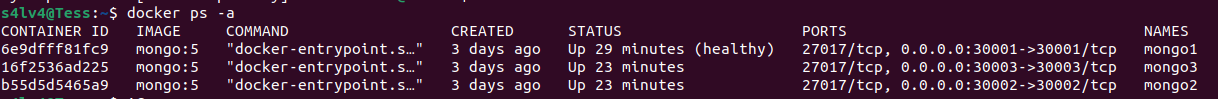

- y quien es el contenedor primario en este momento

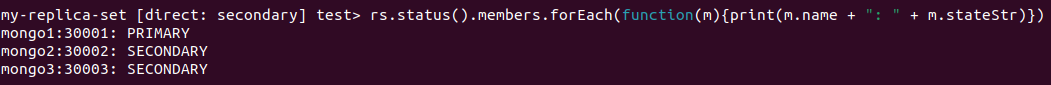

- Ahora desde docker apagamos el contenedor mongo1

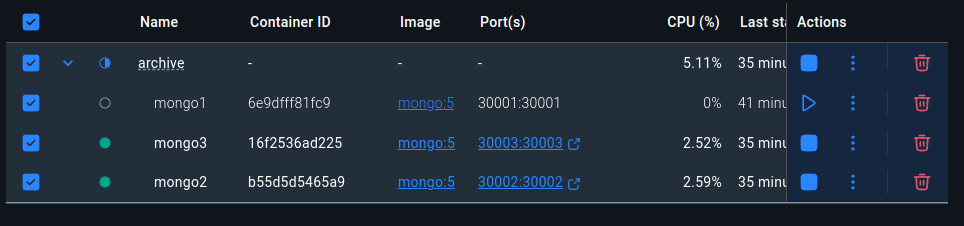

- Revisamos si se traspaso a uno secundario los labores del primario

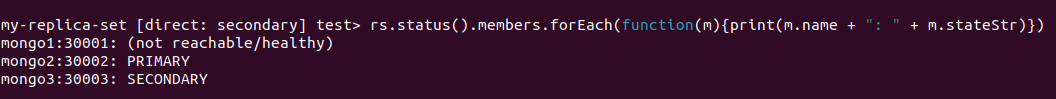

- Y realizamos una consulta para revisar si el usuario notaria el cambio

In [24]:
#obtenemos los articulos que tengan la categoria deseada y que tengan autores
consulta = {
    "categories": {"$in": ["cs.AI", "stat.ML"]},
    "authors_parsed": {"$exists": True, "$ne": None}
}

#Filtramos a los que sean mayor o igual a 3
filtrar_por_autores = {
    "$expr": {"$gte": [{"$size": "$authors_parsed"}, 3]}
}

#Datos a mostrar
proyeccion = {
    "title": 1,
    "authors": 1,
    "_id": 0
}

#Ejecutamos la consulta limitando a 10 resultados
resultados = collection.find({**consulta, **filtrar_por_autores}, proyeccion).limit(10)
print_resultados(resultados)

{'authors': 'Juliana S Bernardes, Alberto Davila, Vitor Santos Costa, Gerson\n  Zaverucha', 'title': 'A study of structural properties on profiles HMMs'}
{'authors': 'Tarik Hadzic, Rune Moller Jensen, Henrik Reif Andersen', 'title': 'Calculating Valid Domains for BDD-Based Interactive Configuration'}
{'authors': 'J. Uglov, V. Schetinin, C. Maple', 'title': 'Comparing Robustness of Pairwise and Multiclass Neural-Network Systems\n  for Face Recognition'}
{'authors': "Christian Gagn\\'e (INFORMATIQUE WGZ INC.), Mich\\`ele Sebag (INRIA\n  Futurs), Marc Schoenauer (INRIA Futurs), Marco Tomassini (ISI)", 'title': 'Ensemble Learning for Free with Evolutionary Algorithms ?'}
{'authors': 'Tshilidzi Marwala, Unathi Mahola and Snehashish Chakraverty', 'title': 'Fault Classification in Cylinders Using Multilayer Perceptrons, Support\n  Vector Machines and Guassian Mixture Models'}
{'authors': 'Ishmael S. Msiza, Fulufhelo V. Nelwamondo and Tshilidzi Marwala', 'title': 'Artificial Neural Networks an

- Con esto comprobamos como funcionan perfectamente el set en caso de que se caiga un conteiner

    Observacion: En caso de la caida de 2 de los 3 set, la asignacion a primario no se podra realizar debido a la "Regla de la mayoria" de MongoDB, en donde se requiere un voto mayoritario para el cambio de configuracion de conteiners y al solo haber 1 disponible, esta mayoria no se puede alcanzar.

### Consistencia de datos
- Partimos revisando el estado de nuestros conteiner y la configuracion de esta

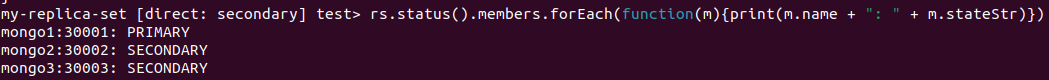

- Ahora comprobamos el funcionamiento de la consistencia, insertando una tabla y editandola, y viendo como se comporta el set

In [26]:

# --- Función para imprimir un documento (para verificación) ---
def print_document(doc, message=""):
    if message:
        print(f"\n--- {message} ---")
    if doc:
        # Usamos json.dumps para imprimir el documento de forma bonita y legible
        print(json.dumps(doc, indent=2))
    else:
        print("Documento no encontrado.")

#Articulo Para el testeo
nuevo_articulo = {
    "id": "2025.TEST.INSERT",
    "submitter": "Demo User",
    "title": "Artículo de Prueba para Consistencia de Inserción",
    "update_date": "2025-06-11",
    "categories": ["test.consistency"],
    "authors": "Demo User",
    "authors_parsed": [["User", "Demo"]]
}

print("\n--- Demostración de Consistencia: Inserción ---")

print("\nVerificando si el artículo existe antes de la inserción (debería ser null):")
doc_before_insert = collection.find_one({"id": "2025.TEST.INSERT"}, {"_id": 0, "title": 1})
print_document(doc_before_insert)

print("\nRealizando inserción en el Primary...")
collection.insert_one(nuevo_articulo)
print("Artículo insertado.")

print("\nVerificando inserción en el Primary:")
doc_after_insert_primary = collection.find_one({"id": "2025.TEST.INSERT"}, {"_id": 0, "title": 1})
print_document(doc_after_insert_primary)

# Esperar un momento para la replicación
print("\nEsperando un momento para la replicación...")
time.sleep(2) # Espera 2 segundos

# Conectar a un secundario para verificar (o ajustar readPreference si tu cliente principal ya es flexible)
# Por claridad en la demo, es útil una conexión directa
secondary_client = MongoClient("mongodb://mongo3:30003/?directConnection=true") # Conéctate directamente a un secundario
secondary_db = secondary_client.arxiv_db
secondary_collection = secondary_db.articles

print("\nVerificando inserción en un nodo Secondary (mongo3):")
doc_after_insert_secondary = secondary_collection.find_one({"id": "2025.TEST.INSERT"}, {"_id": 0, "title": 1})
print_document(doc_after_insert_secondary)
# Cerramos la conexión al secundario después de la prueba
secondary_client.close()



--- Demostración de Consistencia: Inserción ---

Verificando si el artículo existe antes de la inserción (debería ser null):
Documento no encontrado.

Realizando inserción en el Primary...
Artículo insertado.

Verificando inserción en el Primary:
{
  "title": "Art\u00edculo de Prueba para Consistencia de Inserci\u00f3n"
}

Esperando un momento para la replicación...

Verificando inserción en un nodo Secondary (mongo3):
{
  "title": "Art\u00edculo de Prueba para Consistencia de Inserci\u00f3n"
}


esto demuestra como se cumple la consistencia de datos, al revisar como se inserto el articulo en ambos conteiners